# Finetuning of BERT: Single Label (Veg)

In [102]:
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EvalPrediction

import torch
import numpy as np
import pandas as pd
import random

from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from datasets import load_dataset, Features, Value, DatasetDict
from tqdm import tqdm

seed = 6
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [103]:
df = load_dataset('csv', data_files='dataset/recipes_80k_cleaned.csv')

In [104]:
# see datatype of df
print(type(df))

<class 'datasets.dataset_dict.DatasetDict'>


In [105]:
df.keys()

dict_keys(['train'])

In [106]:
df['train'].features

{'Unnamed: 0': Value(dtype='int64', id=None),
 'cooking_method': Value(dtype='string', id=None),
 'ingredients': Value(dtype='string', id=None),
 'recipe_name': Value(dtype='string', id=None),
 'tags': Value(dtype='string', id=None),
 'Vegetarian&Desserts': Value(dtype='int64', id=None),
 'Vegetarian': Value(dtype='int64', id=None),
 'Dairy Free': Value(dtype='int64', id=None),
 'Gluten Free': Value(dtype='int64', id=None),
 'Low Carb': Value(dtype='int64', id=None),
 'Low Fat': Value(dtype='int64', id=None),
 'Low Sodium': Value(dtype='int64', id=None)}

In [107]:
# drop the first column
df['train'] = df['train'].remove_columns('Unnamed: 0')

In [108]:
# first 5 instances of dataset
df['train'][:5]

{'cooking_method': ["['Set the racks in the middle and upper thirds of the oven and preheat the oven to 425 F', 'In a large skillet over medium heat, heat the olive oil until shimmering. Add the onion, garlic and red pepper flakes and cook until golden, stirring occasionally, about 5 minutes.', 'Add the fennel and cook until the vegetables are soft and translucent, an additional 3 to 5 minutes.', 'Reduce the heat to medium and add the tomatoes with their juices. Using the back of a wooden spoon, smash the tomatoes and cook for 5 minutes.', 'Add the basil, wine, olives, 1 teaspoon salt, and 1/8 teaspoon black pepper.', 'Reduce to low and simmer for 15 minutes, or until the sauce is slightly thickened, while you prepare the fish.', 'Pat the fillets dry, lightly spray them with cooking spray, and season with salt and pepper.', 'In a heavy ovenproof skillet over high heat, heat the olive oil until shimmering. Add the fillets, rounded-side down, and cook for 2 minutes.', 'Carefully flip the

## Data Casting
As we can see a few cells above, the first 4 features are already in the wanted data type: `string`. Let's cast the others into `bool` (... and make other adjustments). 

In [109]:
# REMOVE columns Vegetarian, Others
df = df.remove_columns(['Vegetarian'])

df['train'].features

{'cooking_method': Value(dtype='string', id=None),
 'ingredients': Value(dtype='string', id=None),
 'recipe_name': Value(dtype='string', id=None),
 'tags': Value(dtype='string', id=None),
 'Vegetarian&Desserts': Value(dtype='int64', id=None),
 'Dairy Free': Value(dtype='int64', id=None),
 'Gluten Free': Value(dtype='int64', id=None),
 'Low Carb': Value(dtype='int64', id=None),
 'Low Fat': Value(dtype='int64', id=None),
 'Low Sodium': Value(dtype='int64', id=None)}

In [110]:
# RENAME columns Vegetarian&Dessert to Veg, Others&Dessert to NonVeg

# Define a function to rename columns
def rename_columns(example):
    # Rename 'Vegetarian&Dessert' to 'Veg'
    if 'Vegetarian&Desserts' in example:
        example['Veg'] = example.pop('Vegetarian&Desserts')
    # Rename 'Others&Dessert' to 'NonVeg'
    if 'Others&D' in example:
        example['NonVeg'] = example.pop('Others&D')
    return example

# Apply the rename_columns function to each example in the dataset
for split in df.keys():
    df[split] = df[split].map(rename_columns)

df['train'].features

{'cooking_method': Value(dtype='string', id=None),
 'ingredients': Value(dtype='string', id=None),
 'recipe_name': Value(dtype='string', id=None),
 'tags': Value(dtype='string', id=None),
 'Dairy Free': Value(dtype='int64', id=None),
 'Gluten Free': Value(dtype='int64', id=None),
 'Low Carb': Value(dtype='int64', id=None),
 'Low Fat': Value(dtype='int64', id=None),
 'Low Sodium': Value(dtype='int64', id=None),
 'Veg': Value(dtype='int64', id=None)}

In [111]:
# CAST variables to boolean
df['train'] = df['train'].cast(Features({
    'cooking_method' : Value('string'),
    'ingredients' : Value('string'),
    'recipe_name' : Value('string'),
    'tags' : Value('string'),
    'Dairy Free': Value('bool'),
    'Gluten Free': Value('bool'),
    'Low Carb': Value('bool'),
    'Low Fat': Value('bool'),
    'Low Sodium': Value('bool'),
    'Veg': Value('bool')
}))

df['train'].features

{'cooking_method': Value(dtype='string', id=None),
 'ingredients': Value(dtype='string', id=None),
 'recipe_name': Value(dtype='string', id=None),
 'tags': Value(dtype='string', id=None),
 'Dairy Free': Value(dtype='bool', id=None),
 'Gluten Free': Value(dtype='bool', id=None),
 'Low Carb': Value(dtype='bool', id=None),
 'Low Fat': Value(dtype='bool', id=None),
 'Low Sodium': Value(dtype='bool', id=None),
 'Veg': Value(dtype='bool', id=None)}

## Split

In [11]:
# Percentage of Veg recipes
sum(df['train']['Veg'])/len(df['train'])*100

33.50841116864455

In [12]:
# count how many recipes have 'cooking_method' of more than 512 tokens

"""count = 0
for i in tqdm(range(len(df['train']))):
    if len(df['train']['cooking_method'][i].split()) > 512:
        count += 1

print(count)"""

"count = 0\nfor i in tqdm(range(len(df['train']))):\n    if len(df['train']['cooking_method'][i].split()) > 512:\n        count += 1\n\nprint(count)"

In [112]:
# drop these instances
df['train'] = df['train'].filter(lambda x: len(x['cooking_method'].split()) <= 512)

In [113]:

len(df['train'])

79375

In [114]:
sum(df['train']['Veg'])/len(df['train'])*100

33.1867716535433

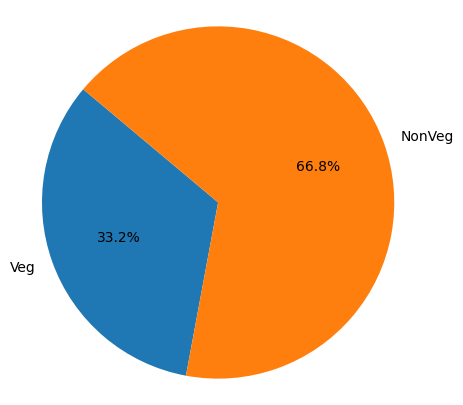

In [115]:
# plot cake plot with 'Veg' and 'NonVeg' recipes distribution
import matplotlib.pyplot as plt

# Count the number of 'Veg' and 'NonVeg' recipes
veg_count = sum(df['train']['Veg'])
non_veg_count = len(df['train']) - veg_count

# Create a pie chart
plt.figure(figsize=(5,5))
plt.pie([veg_count, non_veg_count], labels=['Veg', 'NonVeg'], autopct='%1.1f%%', startangle=140)
plt.axis('equal')

# Display the pie chart
plt.show()

In [16]:
# order the dataset based on 'Veg' label
df['train'] = df['train'].sort('Veg', reverse=True)





In [17]:
#count the number of instances with 'Veg' label as True
sum(df['train']['Veg'])

26342

In [18]:
# reduce the df to the first 26342*2 instances
df['train'] = df['train'].select(range(26342*2))

In [19]:
len(df['train'])

52684

In [20]:
sum(df['train']['Veg'])

26342

In [21]:
#shuffle the dataset
df['train'] = df['train'].shuffle(seed=seed)

In [22]:
# column we want to stratify with respect to
stratify_column_name = "Veg"

# create class label column and stratify
df['train'] = df['train'].class_encode_column(stratify_column_name)

In [23]:
df['train'].features

{'cooking_method': Value(dtype='string', id=None),
 'ingredients': Value(dtype='string', id=None),
 'recipe_name': Value(dtype='string', id=None),
 'tags': Value(dtype='string', id=None),
 'Dairy Free': Value(dtype='bool', id=None),
 'Gluten Free': Value(dtype='bool', id=None),
 'Low Carb': Value(dtype='bool', id=None),
 'Low Fat': Value(dtype='bool', id=None),
 'Low Sodium': Value(dtype='bool', id=None),
 'Veg': ClassLabel(names=['False', 'True'], id=None)}

In [24]:
# see percentage of Veg == True 
sum(df['train']['Veg'])/len(df['train'])*100

50.0

In [25]:
# split the dataset into train, validation and test stratifying with respect to Veg
df = df['train'].train_test_split(test_size=0.3, seed = seed, stratify_by_column = 'Veg')
train_validation = df['train'].train_test_split(test_size=0.2, seed = seed, stratify_by_column='Veg')

dataset = DatasetDict()
dataset['test'] = df['test']
dataset['train'] = train_validation['train']
dataset['validation'] = train_validation['test']
dataset.shape

{'test': (15806, 10), 'train': (29502, 10), 'validation': (7376, 10)}

In [26]:
# CAST 'Veg' back to boolean for split in dataset.keys()
dataset = dataset.cast(Features({
    'cooking_method' : Value('string'),
    'ingredients' : Value('string'),
    'recipe_name' : Value('string'),
    'tags' : Value('string'),
    'Dairy Free': Value('bool'),
    'Gluten Free': Value('bool'),
    'Low Carb': Value('bool'),
    'Low Fat': Value('bool'),
    'Low Sodium': Value('bool'),
    'Veg': Value('bool')
}))

In [27]:
dataset['train'].features

{'cooking_method': Value(dtype='string', id=None),
 'ingredients': Value(dtype='string', id=None),
 'recipe_name': Value(dtype='string', id=None),
 'tags': Value(dtype='string', id=None),
 'Dairy Free': Value(dtype='bool', id=None),
 'Gluten Free': Value(dtype='bool', id=None),
 'Low Carb': Value(dtype='bool', id=None),
 'Low Fat': Value(dtype='bool', id=None),
 'Low Sodium': Value(dtype='bool', id=None),
 'Veg': Value(dtype='bool', id=None)}

In [28]:
# print the distribution of each label: Veg, Dairy Free, Gluten Free, Low Carb, Low Fat, Low Sodium in the train, test and val set

def class_distribution(dataset, column):
    num_1 = sum(dataset[column])
    num_0 = len(dataset) - num_1
    perc_1 = num_1/len(dataset)*100
    perc_0 = num_0/len(dataset)*100
    if column == 'Veg':
        return f"Vegetarian 1: \t {round(perc_1, 1)}% \t Vegetarian 0:\t {round(perc_0, 1)}%"
    return f"{column} 1: \t {round(perc_1, 1)}% \t {column} 0:\t {round(perc_0, 1)}%"


for split in dataset.keys():
    print(split)
    for column in dataset[split].features:
        if dataset[split].features[column].dtype == 'bool' or dataset[split].features[column].dtype == 'ClassLabel':
            print(class_distribution(dataset[split], column))
    print("\n")

test
Dairy Free 1: 	 0.7% 	 Dairy Free 0:	 99.3%
Gluten Free 1: 	 43.8% 	 Gluten Free 0:	 56.2%
Low Carb 1: 	 4.9% 	 Low Carb 0:	 95.1%
Low Fat 1: 	 12.8% 	 Low Fat 0:	 87.2%
Low Sodium 1: 	 23.5% 	 Low Sodium 0:	 76.5%
Vegetarian 1: 	 50.0% 	 Vegetarian 0:	 50.0%


train
Dairy Free 1: 	 0.8% 	 Dairy Free 0:	 99.2%
Gluten Free 1: 	 44.0% 	 Gluten Free 0:	 56.0%
Low Carb 1: 	 4.7% 	 Low Carb 0:	 95.3%
Low Fat 1: 	 12.2% 	 Low Fat 0:	 87.8%
Low Sodium 1: 	 23.7% 	 Low Sodium 0:	 76.3%
Vegetarian 1: 	 50.0% 	 Vegetarian 0:	 50.0%


validation
Dairy Free 1: 	 0.7% 	 Dairy Free 0:	 99.3%
Gluten Free 1: 	 44.1% 	 Gluten Free 0:	 55.9%
Low Carb 1: 	 5.0% 	 Low Carb 0:	 95.0%
Low Fat 1: 	 12.7% 	 Low Fat 0:	 87.3%
Low Sodium 1: 	 24.0% 	 Low Sodium 0:	 76.0%
Vegetarian 1: 	 50.0% 	 Vegetarian 0:	 50.0%




!!! Notice that from now on it is immediate to switch to the multi-labels case !!!

In [29]:
dataset['train'].features.keys()

dict_keys(['cooking_method', 'ingredients', 'recipe_name', 'tags', 'Dairy Free', 'Gluten Free', 'Low Carb', 'Low Fat', 'Low Sodium', 'Veg'])

In [30]:
labels = [label for label in dataset['train'].features.keys() if label not in ['cooking_method','ingredients','recipe_name','tags', 'Dairy Free', 'Gluten Free', 'Low Carb', 'Low Fat', 'Low Sodium', 'NonVeg']]
labels

['Veg']

In [31]:
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}

id2label, label2id

({0: 'Veg'}, {'Veg': 0})

In [32]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")

c:\Users\chucki\Desktop\projects\HLT-Project\.venv\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [33]:
def preprocess_data(examples):
  # take a batch of texts
  text = examples["cooking_method"]
  # encode them
  encoding = tokenizer(text, padding="max_length", truncation=True, max_length=512)
  # add labels
  labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
  # create numpy array of shape (batch_size, num_labels)
  labels_matrix = np.zeros((len(text), len(labels)))
  # fill numpy array
  for idx, label in enumerate(labels):
    labels_matrix[:, idx] = labels_batch[label]

  encoding["labels"] = labels_matrix.tolist()
  
  return encoding

In [34]:
encoded_dataset = dataset.map(preprocess_data, batched=True, remove_columns=dataset['train'].column_names)

Map:   0%|          | 0/29502 [00:00<?, ? examples/s]

In [35]:
encoded_dataset['train'].features

{'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'labels': Sequence(feature=Value(dtype='float64', id=None), length=-1, id=None)}

In [36]:
i = encoded_dataset['train'][0]['input_ids']
len(i)

512

In [37]:
encoded_dataset['train']['labels'][0]

[0.0]

In [38]:
tokenizer.decode(i)

"[CLS] ['Combine the olive oil. sherry vinegar, shallot, chives, sugar and salt and pepper in a small bowl and whisk together. Let stand for a few minutes to combine flavors. In a large bowl, toss greens, walnuts, Stilton cheese, and pear together. Pack the dressing and greens in separate containers. Before serving, drizzle just enough dressing to cover greens before serving.'] [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

In [39]:
encoded_dataset['train'][0]['labels']

[0.0]

In [40]:
# !!! useful for multi-labels case: see which labels it has
[id2label[idx] for idx, label in enumerate(encoded_dataset['train'][0]['labels']) if label == 1.0]

[]

In [41]:
encoded_dataset.set_format("torch")

In [42]:
type(encoded_dataset)

datasets.dataset_dict.DatasetDict

In [35]:
model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-cased", 
                                                           num_labels=len(labels),
                                                           id2label=id2label,
                                                           label2id=label2id
                                                           )

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Train the model!

In [ ]:
args = TrainingArguments(
    f"google-bert/bert-base-cased",
    evaluation_strategy = "steps",
    save_strategy = "steps",
    save_steps=500,
    eval_steps=500,
    save_total_limit=2,
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    #push_to_hub=True,
)

In [ ]:
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average='micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

# evaluate

In [ ]:
trainer.evaluate()

In [ ]:
trainer.save_model("./models/bert-finetuned-group15")

---
# testing

In [43]:
model = AutoModelForSequenceClassification.from_pretrained("./models/bert-finetuned-veg-group15")
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [90]:
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, recall_score, precision_score, classification_report


def multi_label_metrics_test(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average='micro')
    accuracy = accuracy_score(y_true, y_pred)
    recall_micro = recall_score(y_true, y_pred, average='micro')
    precision_micro = precision_score(y_true, y_pred, average='micro')

    f1_macro_average = f1_score(y_true=y_true, y_pred=y_pred, average='macro')
    recall_macro = recall_score(y_true, y_pred, average='macro')
    precision_macro = precision_score(y_true, y_pred, average='macro')

    f1_weighted_average = f1_score(y_true=y_true, y_pred=y_pred, average='weighted')
    recall_weighted = recall_score(y_true, y_pred, average='weighted')
    precision_weighted = precision_score(y_true, y_pred, average='weighted')

    f1_binary = f1_score(y_true=y_true, y_pred=y_pred, average='binary')
    recall_binary = recall_score(y_true, y_pred, average='binary')
    precision_binary = precision_score(y_true, y_pred, average='binary')
    
    print(labels)

    # do a classification report
    class_report = classification_report(y_true, y_pred, target_names=['NonVeg', 'Veg'])
    print(class_report)
    


    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy,
               'recall': recall_micro,
               'precision': precision_micro,
               'f1_macro': f1_macro_average,
               'recall_macro': recall_macro,
               'precision_macro': precision_macro,
               'f1_weighted': f1_weighted_average,
               'recall_weighted': recall_weighted,
               'precision_weighted': precision_weighted,
                'f1_binary': f1_binary,
                'recall_binary': recall_binary,
                'precision_binary': precision_binary,
                'y_true': y_true,
                'y_pred': y_pred
               }
    
    return metrics, y_true, y_pred

def compute_metrics_test(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result, y_true, y_pred = multi_label_metrics_test(
        predictions=preds, 
        labels=p.label_ids)
    
    cm = confusion_matrix(y_true, y_pred)
    # print the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

    return result

In [91]:
dataset['test']
print("Keys in dataset:", dataset.keys())

# Check the length of the test dataset
print("Length of test dataset:", len(dataset['test']))

print(len(dataset['test']))

Keys in dataset: dict_keys(['test', 'train', 'validation'])
Length of test dataset: 15806
15806


In [92]:
#take first 10 element of encoded_dataset

sub_encoded_dataset = encoded_dataset['test'].select(list(range(5)))

In [93]:
sub_encoded_dataset

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 5
})

  0%|          | 0/1976 [00:00<?, ?it/s]

[[0.]
 [0.]
 [0.]
 ...
 [1.]
 [0.]
 [0.]]
              precision    recall  f1-score   support

      NonVeg       0.94      0.77      0.85      7903
         Veg       0.81      0.95      0.87      7903

    accuracy                           0.86     15806
   macro avg       0.87      0.86      0.86     15806
weighted avg       0.87      0.86      0.86     15806



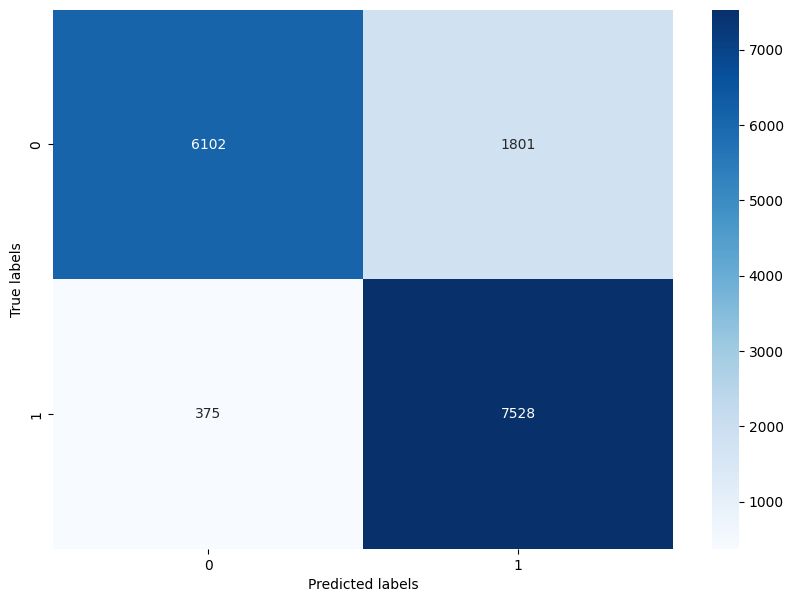

Trainer is attempting to log a value of "[[0.]
 [0.]
 [0.]
 ...
 [1.]
 [0.]
 [0.]]" of type <class 'numpy.ndarray'> for key "eval/y_true" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[[0.]
 [0.]
 [0.]
 ...
 [1.]
 [0.]
 [0.]]" of type <class 'numpy.ndarray'> for key "eval/y_pred" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


In [96]:
trainer = Trainer(
    model=model,
    compute_metrics=compute_metrics_test
)

# Evaluate on the test set
results = trainer.evaluate(eval_dataset=encoded_dataset['test'])

#print(results)

In [97]:
results

{'eval_loss': 0.10050062835216522,
 'eval_f1': 0.8623307604707073,
 'eval_roc_auc': 0.8623307604707073,
 'eval_accuracy': 0.8623307604707073,
 'eval_recall': 0.8623307604707073,
 'eval_precision': 0.8623307604707073,
 'eval_f1_macro': 0.8612010129616213,
 'eval_recall_macro': 0.8623307604707073,
 'eval_precision_macro': 0.8745244537458361,
 'eval_f1_weighted': 0.8612010129616212,
 'eval_recall_weighted': 0.8623307604707073,
 'eval_precision_weighted': 0.8745244537458361,
 'eval_f1_binary': 0.8737233054781801,
 'eval_recall_binary': 0.9525496646842971,
 'eval_precision_binary': 0.8069460821095509,
 'eval_y_true': array([[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [0.],
        [0.]], dtype=float32),
 'eval_y_pred': array([[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [0.],
        [0.]]),
 'eval_runtime': 1365.0123,
 'eval_samples_per_second': 11.579,
 'eval_steps_per_second': 1.448}

C:\Users\chucki\AppData\Local\Temp\ipykernel_13636\3414195251.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette='viridis')


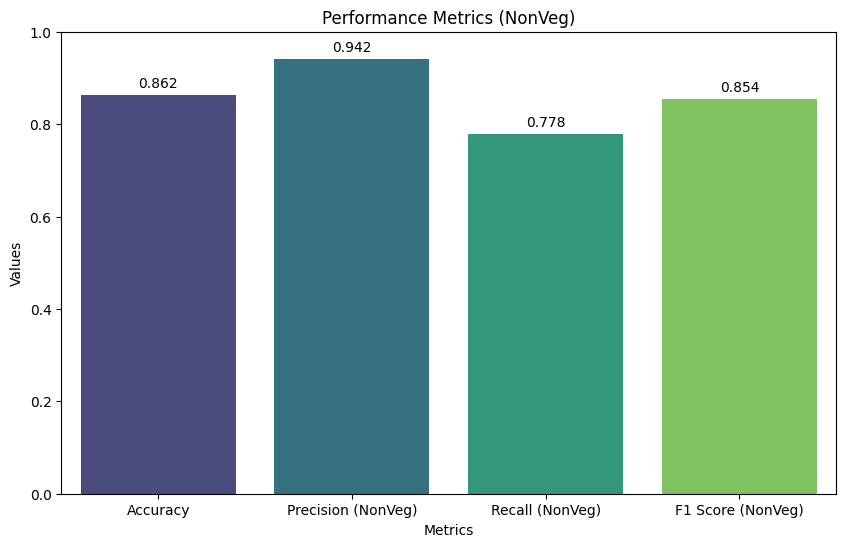

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics
accuracy = 0.8623307604707073
precision = 0.942
recall = 0.778
f1_score = 0.854

# Plotting Accuracy, Precision, Recall, and F1 Score
metrics = ['Accuracy', 'Precision (NonVeg)', 'Recall (NonVeg)', 'F1 Score (NonVeg)']
values = [accuracy, precision, recall, f1_score]

plt.figure(figsize=(10, 6))
sns.barplot(x=metrics, y=values, palette='viridis')
plt.title('Performance Metrics (NonVeg)')
plt.ylim(0, 1)
for i in range(len(values)):
    plt.text(i, values[i] + 0.01, f'{values[i]:.3f}', ha='center', va='bottom')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.show()
